In [2]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

In [8]:
path = 'C:\\Users\\faiza\\Cats vs Dogs Deep Learning\\'

TRAIN_DIR = path + 'train'
TEST_DIR = path + 'test1'

IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '4conv-basic') # just so we remember which saved model is which, sizes must match

In [3]:
def label_img(img):
    word_label = img.split('.')[-3]
    
    # conversion to array [cat,dog]
    if word_label == 'cat': return [1,0] 
                            
    elif word_label == 'dog': return [0,1]

In [17]:
def create_train_data():
    training_data = []
    
    for img in tqdm(os.listdir(TRAIN_DIR)):
        
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)

        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        training_data.append([np.array(img), np.array(label)])
    
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    
    return training_data

In [18]:
def process_test_data():
    testing_data = []
    
    for img in tqdm(os.listdir(TEST_DIR)):
        
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    
    return testing_data

In [10]:
#train_data = create_train_data()
# If you have already created the dataset:
train_data = np.load('train_data.npy', allow_pickle=True)

In [ ]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf

tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [12]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Users\faiza\Cats vs Dogs Deep Learning\dogsvscats-0.001-4conv-basic.model
model loaded!


In [9]:
train = train_data[:-500]
test = train_data[-500:]

In [10]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE,1)
test_y = [i[1] for i in test]

In [11]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1914  | total loss: 0.38209 | time: 30.315s
| Adam | epoch: 005 | loss: 0.38209 - acc: 0.8240 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.37614 | time: 31.390s
| Adam | epoch: 005 | loss: 0.37614 - acc: 0.8260 | val_loss: 0.46858 - val_acc: 0.7880 -- iter: 24500/24500
--


In [12]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\faiza\Cats vs Dogs Deep Learning\dogsvscats-0.001-4conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


# To run tensorboard: 

cd /path/to/log

tensorboard --logdir=./

Go to http://localhost:6006/

# Model Accuracy: 
![title](img/6LayerModelAccuracyMetrics.png)
![title](img/6LayerModelAccuracyMetrics2.png)

# Model Attributes: 
![title](img/fit_dogsvscats-0.001-4conv-basic.model.png)

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir=foo:'C:\\Users\\faiza\\Cats vs Dogs Deep Learning\\log'
#file_writer = tf.summary.FileWriter('C:\\Users\\faiza\\Cats vs Dogs Deep Learning\\log', sess.graph)
#%tensorboard --logdir foo:"C:\Users\faiza\Cats vs Dogs Deep Learning\log"

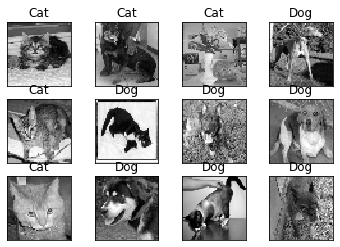

In [37]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# if you need to create the data:
#test_data = process_test_data()
# if you already have some saved:
test_data = np.load('test_data.npy', allow_pickle=True)

fig = plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
    
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()